# TP53 Graph Classification - Main Experiment
Predicting TP53 mutation status using single-cell RNA-seq and Graph Neural Networks.


## Setup

In [37]:
import os
import sys
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import mygene
sys.path.append(os.path.abspath("../src"))
import importlib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.stats
import math
from torch_geometric.transforms import LargestConnectedComponents
import torch_geometric.utils as tg_utils
from torch_geometric.data import Data 
import networkx as nx
import torch
import seaborn as sns
import gc
from pathlib import Path



import load_data
import preprocessing
import network_constructor
import model_constructor

## Data import 

In [38]:
adata = load_data.load_expression_data( "../data/Expression_Matrix", verbosity=True)
df_expression=ad.AnnData.to_df(adata)
df_expression.head()


df_expression shape: (35276, 47096)
df_expression columns: Index(['ENSG00000000003', 'ENSG00000000419', 'ENSG00000000457',
       'ENSG00000000460', 'ENSG00000001036', 'ENSG00000001084',
       'ENSG00000001167', 'ENSG00000001460', 'ENSG00000001461',
       'ENSG00000001497',
       ...
       'ENSG00000271681', 'ENSG00000276605', 'ENSG00000277206',
       'ENSG00000277591', 'ENSG00000278658', 'ENSG00000279270',
       'ENSG00000280920', 'ENSG00000283420', 'ENSG00000284003',
       'ENSG00000284685'],
      dtype='object', length=47096)
df_expression head:                     ENSG00000000003  ENSG00000000419  ENSG00000000457  \
AU565_AAACCAGTTTGG              0.0              2.0              0.0   
AU565_AAACGTGCAGCG              1.0              0.0              0.0   
AU565_AAAGCCACATGC              0.0              2.0              0.0   
AU565_AAAGTCGGCTGG              0.0              0.0              0.0   
AU565_AAAGTGCCTAAA              0.0              2.0              0.0   

,ENSG00000000003,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,ENSG00000001497,...,ENSG00000271681,ENSG00000276605,ENSG00000277206,ENSG00000277591,ENSG00000278658,ENSG00000279270,ENSG00000280920,ENSG00000283420,ENSG00000284003,ENSG00000284685
AU565_AAACCAGTTTGG,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AU565_AAACGTGCAGCG,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AU565_AAAGCCACATGC,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AU565_AAAGTCGGCTGG,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AU565_AAAGTGCCTAAA,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
df_mutation = load_data.load_mutation_data("../data/Mutation/CellLineDownload_r21.csv", verbosity=True)
df_mutation = load_data.add_cleaned_column(df_mutation, column_name="Sample_Name")
df_mutation.head()

df_mutation shape: (2913, 80)
df_mutation columns: Index(['Sample_Name', 'ATCC_ID', 'Cosmic_ID', 'Short_topo', 'Morphology',
       'Tumor_origin', 'Add_info', 'Sex', 'Age', 'Country', 'Population',
       'Germline_mutation', 'Infectious_agent', 'Tobacco', 'Alcohol',
       'Exposure', 'KRAS_status', 'Other_mutations', 'TP53status', 'p53_IHC',
       'TP53_LOH', 'MUT_ID', 'hg18_Chr17_coordinates',
       'hg19_Chr17_coordinates', 'hg38_Chr17_coordinates', 'ExonIntron',
       'Codon_number', 'Description', 'Type', 'c_description', 'g_description',
       'g_description_GRCh38', 'WT_nucleotide', 'Mutant_nucleotide',
       'WT_codon', 'Mutant_codon', 'WT_AA', 'Mutant_AA', 'Effect',
       'ProtDescription', 'COSMIClink', 'TCGA_ICGC_GENIE_count', 'Hotspot',
       'AGVGDClass', 'SIFTClass', 'Polyphen2', 'REVEL', 'BayesDel',
       'StructureFunctionClass', 'TransactivationClass', 'DNEclass',
       'DNE_LOFclass', 'WAF1nWT', 'MDM2nWT', 'BAXnWT', 'AIP1nWT', 'h1433snWT',
       'GADD45nWT

,Sample_Name,ATCC_ID,Cosmic_ID,Short_topo,Morphology,Tumor_origin,Add_info,Sex,Age,Country,...,exon3,exon4,exon5,exon6,exon7,exon8,exon9,exon10,exon11,Sample_Name_cleaned
Sample_ID,,,,,,,,,,,,,,,,,,,,,
2946,SW13,CCL-105,909744.0,ADRENAL GLAND,Adrenal cortical carcinoma (C74.0),NaN,NaN,F,55.0,NaN,...,False,False,True,True,True,True,False,False,False,SW13
24833,NCI-H295,CRL-10296,908466.0,ADRENAL GLAND,Adrenal cortical carcinoma (C74.0),NaN,NaN,F,48.0,NaN,...,False,False,True,True,True,True,False,False,False,NCIH295
24979,NCI-H295R,CRL-2128,NaN,ADRENAL GLAND,Adrenal cortical carcinoma (C74.0),primary,Derived from NCI-H295 cell line,F,48.0,NaN,...,True,True,True,True,True,True,True,True,True,NCIH295R
21569,NCI-H295,CRL-10296,908466.0,ADRENAL GLAND,Adrenal cortical carcinoma (C74.0),NaN,NaN,F,48.0,NaN,...,True,True,True,True,True,True,True,True,True,NCIH295
21329,ETK-1,NaN,906861.0,BILIARY TRACT,"Adenocarcinoma, NOS",NaN,NaN,F,NaN,NaN,...,True,True,True,True,True,True,True,True,True,ETK1


# EDA and Preprocessing

In [40]:
#Gene mapping
preprocessing.get_genes_symbols(adata, "gene_symbols")
print(adata.var['gene_symbols_mapped'].unique())

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
22 input query terms found dup hits:	[('ENSG00000215156', 2), ('ENSG00000227110', 2), ('ENSG00000228566', 2), ('ENSG00000280018', 2), ('E
928 input query terms found no hit:	['ENSG00000112096', 'ENSG00000130723', 'ENSG00000168078', 'ENSG00000189144', 'ENSG00000205485', 'ENS


['TSPAN6' 'DPM1' 'SCYL3' ... 'MIR4278' 'ENSG00000284003' 'ENSG00000284685']


In [41]:
#Add mutation status to adata
preprocessing.add_mutation_column(adata, df_mutation, cell_lines_column_name = "Sample_Name_cleaned", mutation_status_column="TP53status", new_obs_column="mutation_status")

Cell lines not found in df_mutation: ['HS578T' 'MCF12A' 'MX1' 'MDAMB453']
Removed 4562 cells with unknown mutation status.
Number matching lines: 30714
Percentage of matching cell: 87.07%


In [42]:
########################################################################################################################################
########################################################################################################################################
########################################################################################################################################

In [43]:
#df_expression.shape

In [44]:
# #TROPPO GRANDE ANCHE PER IL CLUSTER (47096 X 47096)
# tp53_target_path = "../data/Target_genes/41388_2017_BFonc2016502_MOESM5_ESM_tab1.xlsx"
# plot_correlation_comparison(df_expression,tp53_target_path)

In [45]:
########################################################################################################################################
########################################################################################################################################
########################################################################################################################################

In [46]:
#sparsity
preprocessing.check_sparsity(adata)

Number of cells: 30714
Number of genes: 47096
Number of non-zero entries: 100804217
Sparsity: 93.03%


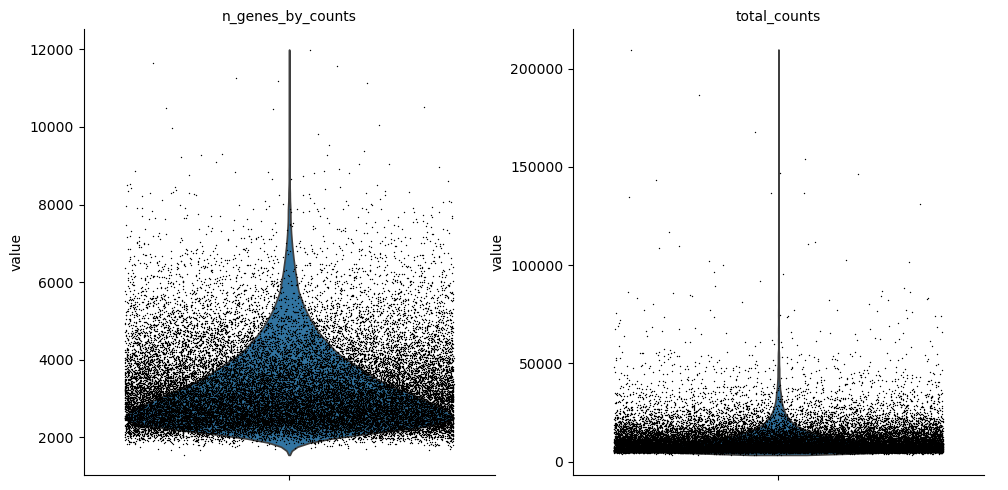

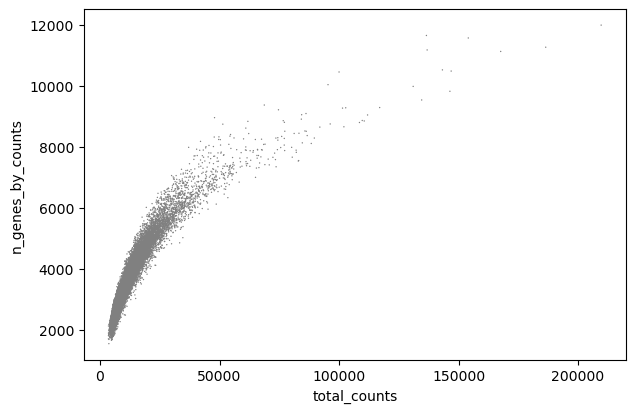

In [47]:
#Quality control
preprocessing.show_qc_plots(adata, violin_cols=['n_genes_by_counts', 'total_counts'], scatter_x='total_counts', scatter_y='n_genes_by_counts')

In [48]:
#dublet detection
sc.pp.scrublet(adata)
print(f"Number of doublets detected: {adata.obs['predicted_doublet'].sum()}")

Number of doublets detected: 0


In [49]:
#Normalization
adata.layers["raw_counts"] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata) 

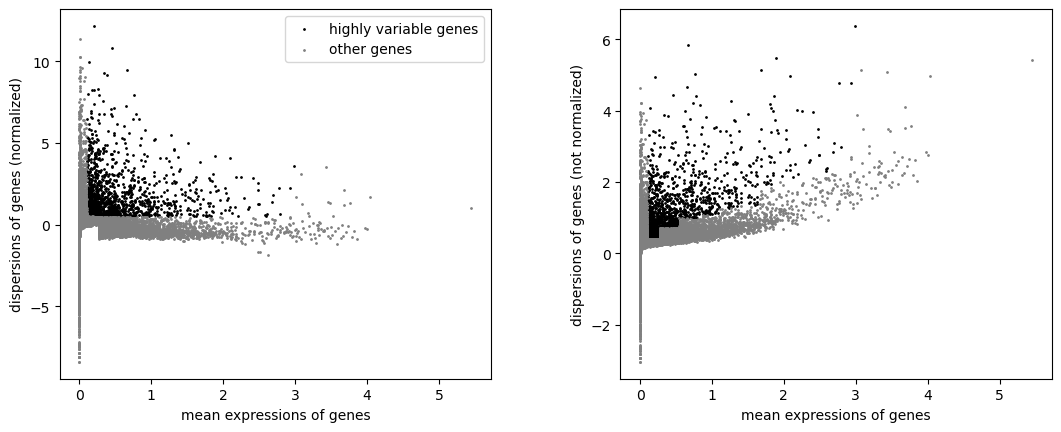

In [ ]:
#Feature selection
adata.layers["pre_feature_selection"] = adata.X.copy()

# sc.pp.highly_variable_genes(
#     adata,
#     n_top_genes=2000)
sc.pp.highly_variable_genes(adata, min_mean=0.1, max_mean=3, min_disp=0.5 )   #BATCH KEY
sc.pl.highly_variable_genes(adata, save="hvgs.png")
adata = adata[:, adata.var.highly_variable]

/opt/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:379: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


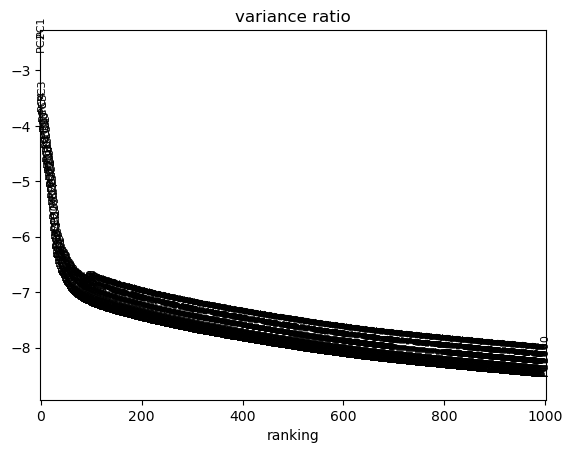

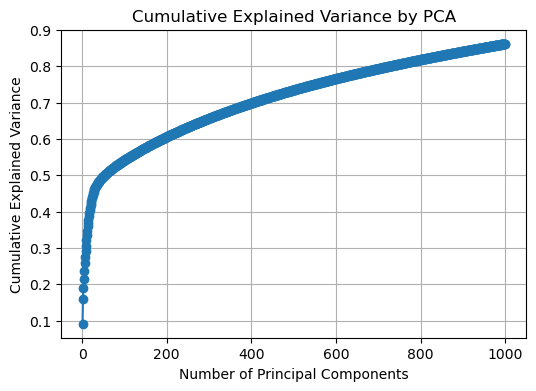

In [51]:
#pca
sc.tl.pca(adata, n_comps=1000)
sc.pl.pca_variance_ratio(adata, n_pcs=1000, log=True)


explained_variance = adata.uns['pca']['variance_ratio']
cumulative_variance = explained_variance.cumsum()


plt.figure(figsize=(6,4))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA')
plt.grid(True)
plt.show()


In [52]:
adata.obs['cell_lines'] = adata.obs_names.str.split('_').str[0]

/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


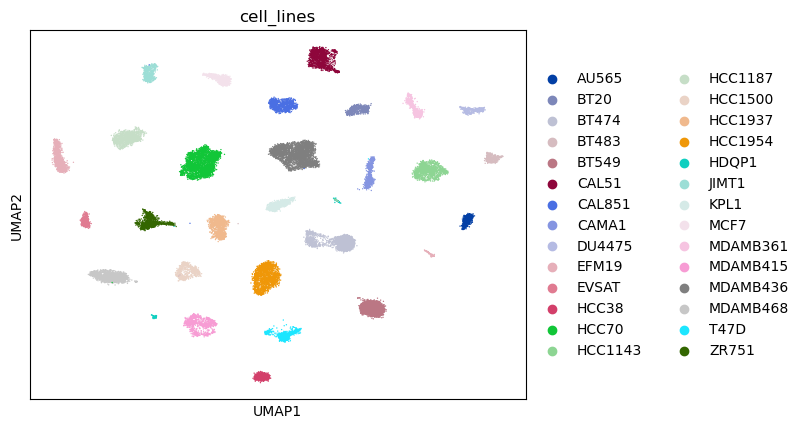

In [53]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color = "cell_lines")


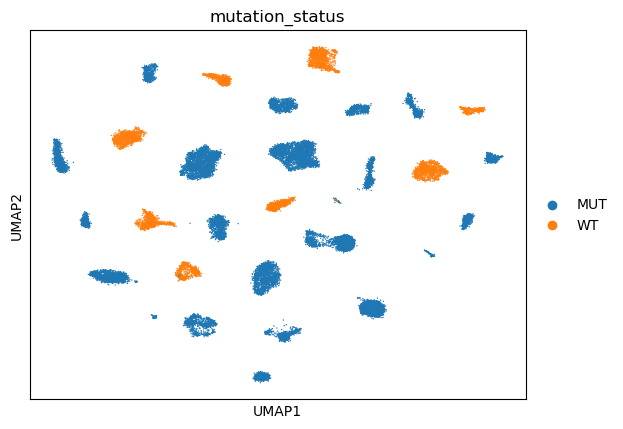

In [54]:
sc.pl.umap(adata, color = "mutation_status")

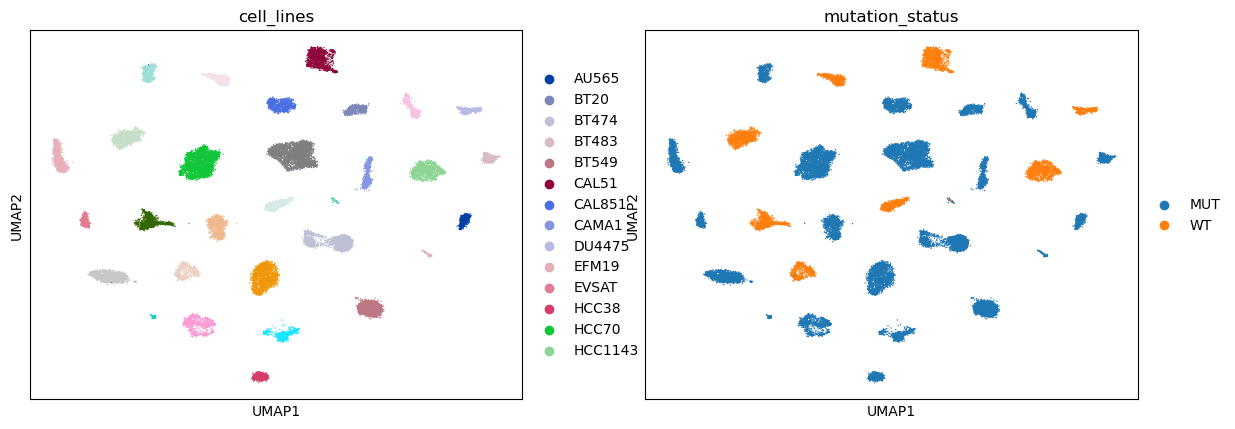

In [55]:
sc.pl.umap(adata, color = ["cell_lines","mutation_status"])

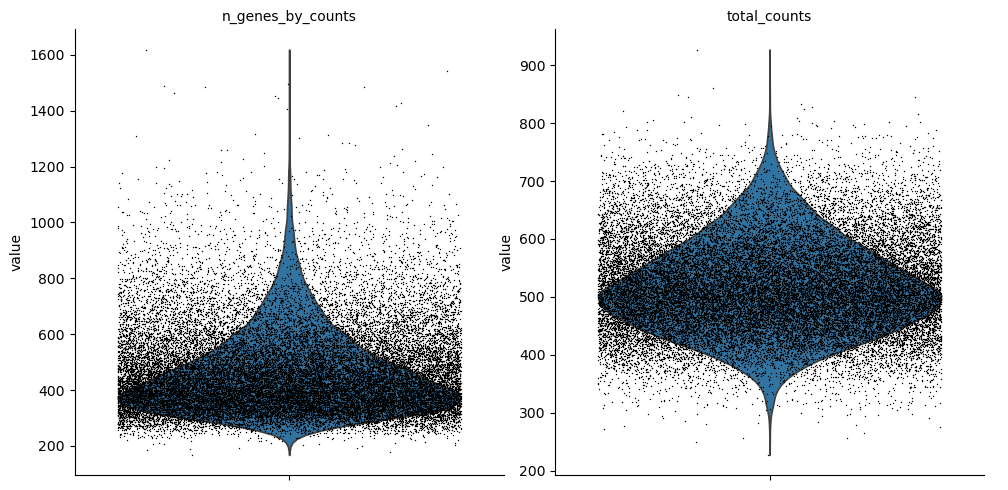

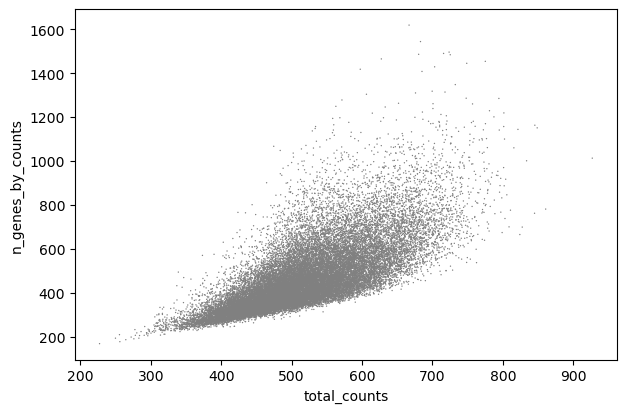

In [56]:
#Final Quality control
preprocessing.show_qc_plots(adata, violin_cols=['n_genes_by_counts', 'total_counts'], scatter_x='total_counts', scatter_y='n_genes_by_counts')

In [57]:
final_df = ad.AnnData.to_df(adata)
final_df["mutation_status"] = adata.obs["mutation_status"].values
final_df.head()

,ENSG00000001084,ENSG00000001461,ENSG00000002834,ENSG00000005884,ENSG00000006282,ENSG00000006459,ENSG00000006757,ENSG00000007944,ENSG00000008283,ENSG00000008838,...,ENSG00000104371,ENSG00000188257,ENSG00000108700,ENSG00000167656,ENSG00000167779,ENSG00000122861,ENSG00000260549,ENSG00000127951,ENSG00000170627,mutation_status
AU565_AAACCAGTTTGG,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,MUT
AU565_AAACGTGCAGCG,0.0,0.000000,0.0,0.0,0.751924,0.000000,0.751924,0.751924,0.751924,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,MUT
AU565_AAAGCCACATGC,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.924988,0.0,0.0,0.0,0.0,0.000000,MUT
AU565_AAAGTCGGCTGG,0.0,0.000000,0.0,0.0,0.000000,0.925356,0.000000,0.000000,0.925356,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.925356,MUT
AU565_AAAGTGCCTAAA,0.0,0.802482,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.546118,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,MUT


In [ ]:
final_df.to_csv("final_preprocessed_data_nuovo.csv")

# Network Construction

In [59]:
df= pd.read_csv("final_preprocessed_data.csv", index_col=0)
df.head()
df.shape

(30714, 3809)

In [60]:
#Split in train and test set
train_df, test_df = network_constructor.train_test_split(df, test_size=0.2, random_state=42)
print(f"shape del train test: {train_df.shape} \nshape del test set: {test_df.shape}")

shape del train test: (24571, 3809) 
shape del test set: (6143, 3809)


Percentage of non-zero values in the correlation matrix: 0.37581112408198575


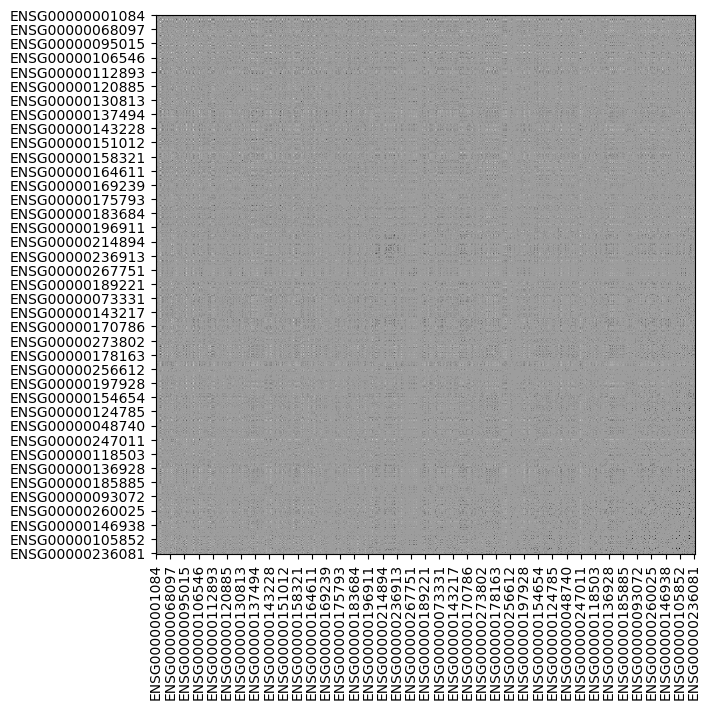

In [ ]:
#Construction of the correlation matrix
mat=network_constructor.build_correlation_matrix(train_df.iloc[:,:-1], corr_threshold=0., p_value_threshold= 1) #PER ORA NO THRESHOLD
network_constructor.check_percentage_of_zeros(mat)
network_constructor.plot_the_correlation_matrix(train_df, mat)

In [62]:
# #COSTRUZIONE DEI GRAFI, LA FACCIAMO SUL CLUSTER QUA NE FACCIAMO SOLO 50 PER TESTARE

# train_df_pyg = network_constructor.create_PyG_graph_from_df(train_df[:50], mat, label_column="mutation_status")
# test_df_pyg = network_constructor.create_PyG_graph_from_df(test_df[:20], mat, label_column="mutation_status")

# #check
# print(f"First element of train_df_pyg: {train_df_pyg[0]}")
# print(f"First element of test_df_pyg: {test_df_pyg[0]}")
# assert network_constructor.check_graph_structure(train_df_pyg), "The graphs in the train set do not have the same structure."
# assert network_constructor.check_graph_structure(test_df_pyg), "The graphs in the test set do not have the same structure."

In [63]:
first_train_batch = torch.load("../data/graphs_no_treshold/train/batch_000.pt", weights_only=False)
first_test_batch = torch.load("../data/graphs_no_treshold/test/batch_000.pt", weights_only=False)

#check
print(f"First element of train_df_pyg: {first_train_batch[0]}")
print(f"First element of test_df_pyg: {first_test_batch[0]}")
assert network_constructor.check_graph_structure(first_train_batch), "The graphs in the train set do not have the same structure."
assert network_constructor.check_graph_structure(first_test_batch), "The graphs in the test set do not have the same structure."

First element of train_df_pyg: Data(x=[3808, 1], edge_index=[2, 3323612], y=[1])
First element of test_df_pyg: Data(x=[3808, 1], edge_index=[2, 3323612], y=[1])


Number of nodes: 3808
Number of edges: 3323612
NUmber of features per node: 1
Has isolated nodes: True
Has self-loops: False
Is undirected: True


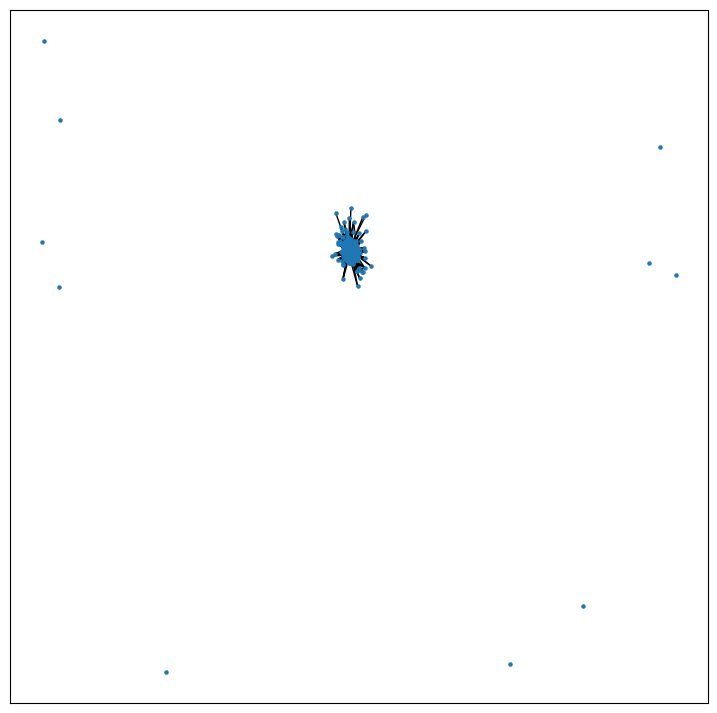

In [64]:
network_constructor.get_info_and_plot_graph(first_train_batch)

# Check on target genes

In [130]:
def plot_frequency_of_correlation_values(matrices, bins=50, alpha=0.5):
    """
    Plot the frequency of correlation values.
    """
    plt.figure(figsize=(10, 6))
    bin_edges = np.linspace(-1, 1, bins + 1)

    for label,mat in matrices.items():
        mat_copia = mat.copy()
        np.fill_diagonal(mat_copia, np.nan) 
        values = mat_copia.flatten()
        plt.hist(values, bins=bin_edges, alpha=alpha, label=label, edgecolor='black') #density=True
        mean_val = np.mean(values)
        plt.axvline(mean_val, linestyle='--', linewidth=2)
    plt.yscale('log')
    plt.legend()
    plt.title('Hist of Correlation Values')
    plt.xlabel('Correlation Value')
    plt.ylabel('Absolute frequence')
    plt.grid(True)
    plt.show()

In [131]:
def import_and_create_matrices_for_plotting(path,mat_name,col_name="Ensembl ID",verbosity=False):
    "Expect to have a column named 'Ensembl ID' in the excel file, can specify the name of the columns otherwise with col_name"
    tab = pd.read_excel(path)
    tab_ensembl_ids = [gene for gene in tab[col_name] if gene in df.columns]
    df_tab = df[tab_ensembl_ids].copy()
    mat_tab=network_constructor.build_correlation_matrix(df_tab, corr_threshold=0., p_value_threshold= 1)
    if verbosity==True:
        df_tab.head()
        network_constructor.check_percentage_of_zeros(mat_tab)
    return mat_tab

In [132]:
def plot_correlation_comparison(df_expression,path_list):
    if not isinstance(path_list, list):
        path_list = [path_list]

    
    mat=network_constructor.build_correlation_matrix(df_expression, corr_threshold=0., p_value_threshold= 1)
    
    plot_frequency_of_correlation_values({"Original":mat}, bins=50, alpha=0.5)
    plt.close("all")
    del mat
    gc.collect()
    
    for path in path_list:
        label= path.split("/")[-1].split(".")[0]
        mat = import_and_create_matrices_for_plotting(path, mat_name=label, col_name="Ensembl ID", verbosity=False)
        plot_frequency_of_correlation_values({label:mat}, bins=50, alpha=0.5)
        del mat
        gc.collect()

In [145]:
#import target genes and create target genes df
tab1 = pd.read_excel('../data/Target_genes/41388_2017_BFonc2016502_MOESM5_ESM_tab1.xlsx')
tab1_ensembl_ids = [gene for gene in tab1["Ensembl ID"] if gene in df.columns]
df_tab1 = df[tab1_ensembl_ids].copy()
mat_tab1=network_constructor.build_correlation_matrix(df_tab1, corr_threshold=0., p_value_threshold= 1, p_val="no") #PER ORA NO THRESHOLD
network_constructor.check_percentage_of_zeros(mat_tab1)
mat_original=network_constructor.build_correlation_matrix(train_df.iloc[:,:-1], corr_threshold=0., p_value_threshold= 1,p_val="no") #PER ORA NO THRESHOLD
network_constructor.check_percentage_of_zeros(mat_original)


Percentage of non-zero values in the correlation matrix: 0.9927536231884058
Percentage of non-zero values in the correlation matrix: 0.9997373949579832


TAB1 è il csv con 350 target tp53 genes

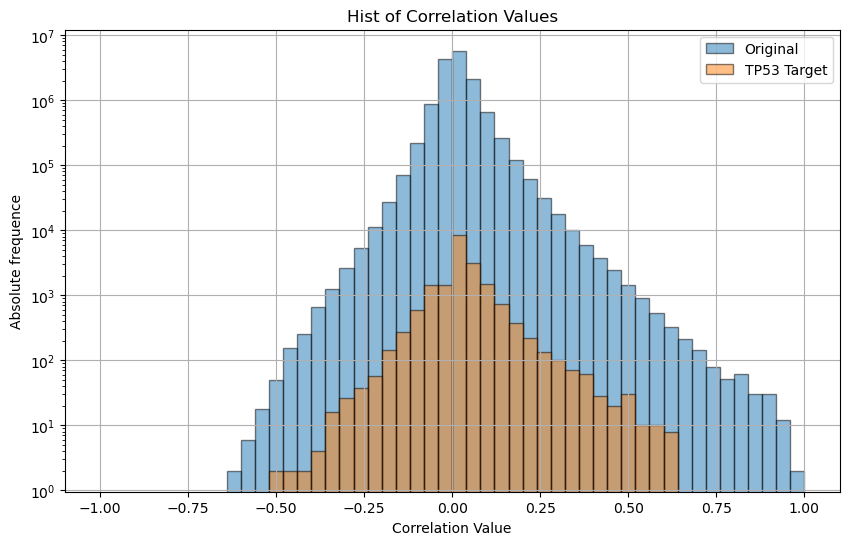

In [143]:
plot_frequency_of_correlation_values({"Original":mat_original,"TP53 Target":mat_tab1})

In [71]:
from scipy.stats import ks_2samp
stat, pval = ks_2samp(mat.flatten(), mat_tab1.flatten())
print(f"KS: {stat}, p-value: {pval}")

KS: 0.18523917829344938, p-value: 0.0


In [83]:
#import bulk data
df_bulk=pd.read_csv("../data/Target_genes/BulkCCLE_da_michele.csv")
df_bulk.head()

,Unnamed: 0,KRT19 (3880),SPARC (6678),C19orf33 (64073),VIM (7431),UCHL1 (7345),TGFBI (7045),KRT7 (3855),RPS4Y1 (6192),FN1 (2335),...,RGS11 (8786),SLC3A1 (6519),LIMK1 (3984),SNX25 (83891),VSIG10 (54621),TEDC1 (283643),ZNF827 (152485),CEP41 (95681),RASD2 (23551),mutation_type
0,ACH-001289,0.443607,6.943570,0.443607,9.940328,9.959553,0.378512,0.000000,8.705909,3.160275,...,0.014355,0.042644,3.735522,5.757290,4.341986,2.914565,0.613532,0.495695,0.298658,wt
1,ACH-000242,10.970609,0.739848,8.044886,1.748461,1.384050,3.190615,11.812258,8.612463,3.427606,...,0.014355,0.042644,3.914565,2.049631,5.226894,5.083213,2.189034,3.025029,0.014355,wt
2,ACH-000708,9.360715,2.632268,7.482203,3.140779,1.150560,5.874059,2.060047,0.948601,3.307429,...,1.959770,2.944858,4.690976,1.992768,4.994580,4.728465,1.589763,1.280956,0.111031,wt
3,ACH-000327,4.431623,0.823749,6.802839,1.475085,5.741197,6.598574,9.222867,0.815575,4.015248,...,2.689299,1.400538,3.951401,1.526069,2.893362,2.916477,2.166715,2.553361,0.443607,wt
4,ACH-001794,0.333424,13.167622,0.000000,11.982851,7.746178,10.725792,2.910733,0.042644,12.332764,...,0.042644,0.042644,5.990047,3.923149,3.276497,3.476382,3.192194,1.918386,0.056584,wt


In [135]:
#convert mutation_type to mut/wt
df_bulk["mutation_type"]= np.where(df_bulk["mutation_type"]=="wt","wt","mut" )
#pulisci colonne
df_bulk.columns=[col.split(" ")[0].strip() for col in df_bulk.columns]
#crea df target bulk
df_bulk_tab1_gene_symbol = [gene for gene in tab1["Gene Symbol"] if gene in df_bulk.columns]
df_tab1_bulk = df_bulk[df_bulk_tab1_gene_symbol].copy()

In [95]:
print(f"shape before target filtering: {df_bulk.shape}")
print(f"shape after target filtering: {df_tab1_bulk.shape}")
n_correspondence = len([col in df.columns[:-1]  for col in df_tab1_bulk.columns] )
print(f"check how many HVG are in target filtered:{n_correspondence} ")

shape before target filtering: (1493, 6100)
shape after target filtering: (1493, 200)
check how many HVG are in target filtered:200 


In [136]:
mat_original_bulk=network_constructor.build_correlation_matrix(df_bulk, corr_threshold=0, p_value_threshold= 1, p_val="no") #PER ORA NO THRESHOLD
network_constructor.check_percentage_of_zeros(mat_original_bulk)
mat_tab1_bulk=network_constructor.build_correlation_matrix(df_tab1_bulk, corr_threshold=0, p_value_threshold= 1, p_val="no") #PER ORA NO THRESHOLD
network_constructor.check_percentage_of_zeros(mat_tab1_bulk)

Percentage of non-zero values in the correlation matrix: 0.9998360655737705
Percentage of non-zero values in the correlation matrix: 0.995


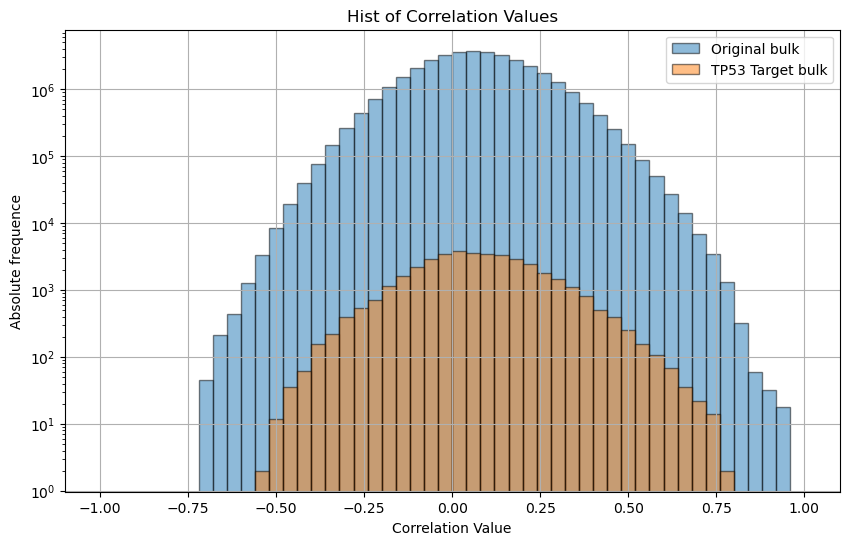

In [141]:
plot_frequency_of_correlation_values({"Original bulk":mat_original_bulk,"TP53 Target bulk":mat_tab1_bulk})

# Test to see if the model works (just for debugging)

In [ ]:
model = model_constructor.train_model(train_PyG=first_train_batch, test_PyG=first_test_batch, epochs = 4, batch_size = 1)

KeyboardInterrupt: 

# Get graph informations (debugging)

Number of nodes: 2449
Number of edges: 157154
NUmber of features per node: 1
Has isolated nodes: False
Has self-loops: False
Is undirected: True


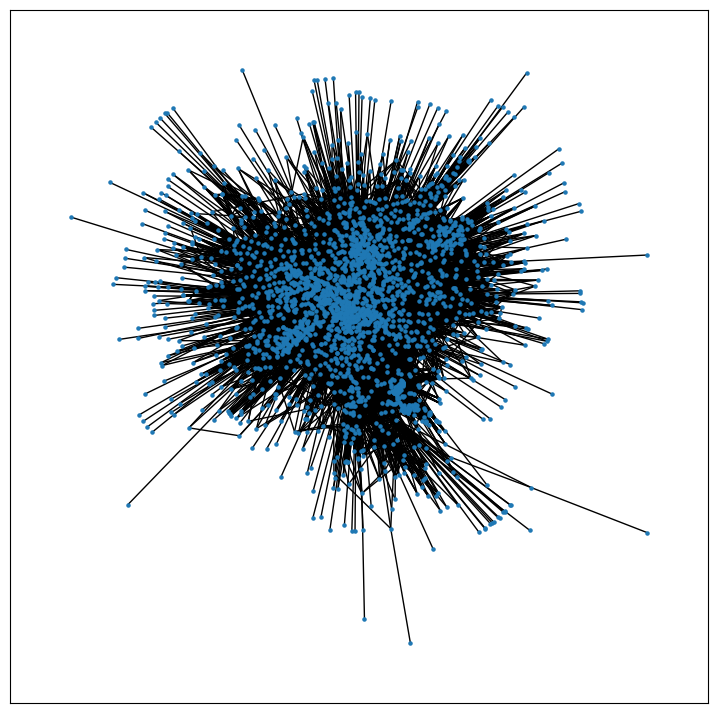

In [76]:
prova_c02_p005_LCC= torch.load("../data/Vari_trial/graphs_02_treshold/batch_000.pt", weights_only=False)
'../data/Vari_trial /graphs_02_treshold'
network_constructor.get_info_and_plot_graph(prova_c02_p005_LCC)

Number of nodes: 3808
Number of edges: 157158
NUmber of features per node: 1
Has isolated nodes: True
Has self-loops: False
Is undirected: True


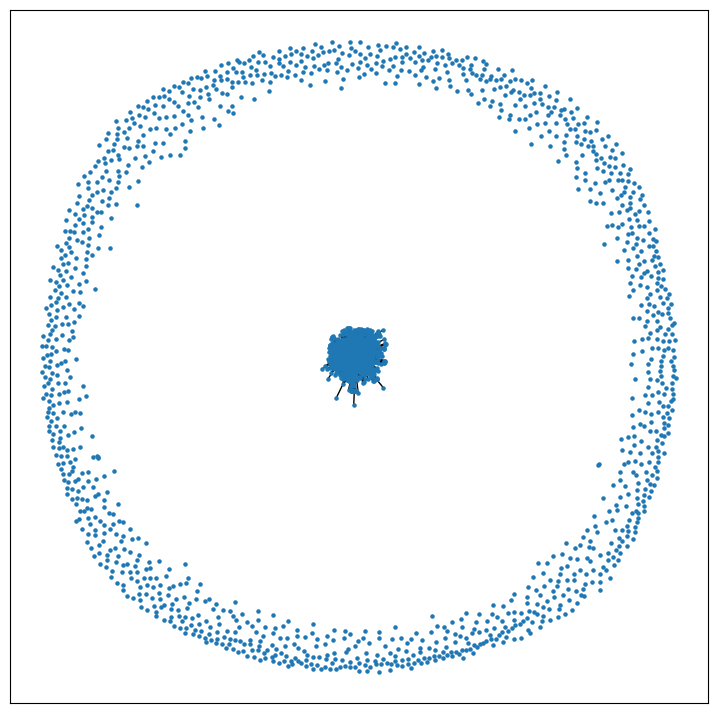

In [77]:
prova_c02_p005_noLCC= torch.load("../data/graphs_c02_p005_noLCC/train/batch_000.pt", weights_only=False)
network_constructor.get_info_and_plot_graph(prova_c02_p005_noLCC)

In [78]:
print(prova_c02_p005_noLCC[0].keys)

<bound method BaseData.keys of Data(x=[3808, 1], edge_index=[2, 157158], y=[1])>


In [79]:
df = pd.read_csv("final_preprocessed_data.csv", index_col=0)
train_df, test_df =train_test_split(df, test_size=0.2, random_state=42)